<center><h2><b><u> Multilayer Perceptron with MNIST Dataset</u></b></h2></center>

### __Importing Libraries, Classes, and Functions__

In [45]:
from operator import itemgetter
import torch
import torch.nn as nn #provides classes/modules for making neural networks
import numpy as np
from torch.nn import Linear
import torch.nn.functional as F #a module with common nn functions (operations on tensors/high dim matrices; activations)
import torch.optim as optim #contains optimization algorithms like SGD
from torchvision import datasets, transforms #includes MNIST, transform images -> tensors
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split #allows shuffling and minbatches
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, ParameterGrid
import os
import shutil
import json
#!pip install torch-xla
#import torch_xla
#import torch_xla.core.xla_model as xm #tpu
#from google.colab import files

### __Initializing the Hyperparameters__

In [46]:
class Hypers:
    def __init__(self, hyperpath):
        with open(hyperpath, 'r') as file:
            hyper_dict = json.load(file)
        self.l_rate = hyper_dict['learning_rate']
        self.b_size = hyper_dict['batch_size']
        self.epochs = hyper_dict['epochs']
        self.drop_rate = hyper_dict['dropout_rate']
        self.hidden_one = hyper_dict['hidden_one']
        self.hidden_two = hyper_dict['hidden_two']
        self.n_slope = hyper_dict['n_slope']

hypers = Hypers('../config/hyperparameters.json')

### __The Model Blueprint__

In [47]:
# with __call__ object name can be treated as function that calls certain function in class (predefine)
#inherits from nn.Module class; many classes for different layers
class NumberNN(nn.Module): 
    def __init__(self, hidden_one, hidden_two, drop_prob, n_slope):
        super(NumberNN, self).__init__() #explicitly call parent class constructor to initialize stuff
                                    #parent (nn.Module) technically initialized too and tied to child but you only access child
        self.fc1 = Linear(in_features = 28**2, out_features = hidden_one) #num features = num neurons in input layer (1 neuron per feature/vector component)
        self.fc2 = Linear(hidden_one, hidden_two)
        self.fc3 = Linear(hidden_two, 10)
        self.n_slope = n_slope

        self.dropout = nn.Dropout(p=drop_prob) 
    
    def forward(self, x):
        '''MNIST is (batch_size = ..., channels = 1, height = 28, width = 28)
        Fully connected layers expect input tensors to be (batch_size, num_features); labels already liked this
        Size of first dimension of tensor is batch size, -1 infers dim of the vector/features (784)
        '''
        x = x.view(-1, 28**2)  # Flatten the input tensor (batch_size, 1, 28, 28) to (batch_size, 784)

        z1 = self.fc1(x) #Weight matrix + bias vector
        a1 = F.leaky_relu(z1, negative_slope= self.n_slope) 
        a1 = self.dropout(a1) #Starting dropout in layer 2; don't drop inputs

        z2 = self.fc2(a1)
        a2 = F.leaky_relu(z2, negative_slope= self.n_slope) 
        a2 = self.dropout(a2)

        outputs = self.fc3(a2) #logits - softmax(logit) = p_class
        
        return outputs

### __Data Loading and Preparation__

In [48]:
#device = xm.xla_device() #Sets up commmunication between CPU and TPU
#device = torch.device("mps")
device = torch.device("cpu")

#increase learning rate since batch size increase -> more accurate gradient -> can take bigger step
#b_size = 128
#epochs = 20

'''Transformation function object applies transformations in list sequentially (e.g. images into tensors 
-> normalize). Normalizing/condensing pixels to 0-1 to make model focuses more on relationships instead
of brightness levels.'''
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

#like list of tuples of (image (tensor), label)...
full_train_dataset = datasets.MNIST(root = '../data', train = True, download = False, transform = transform) #true on Colab

full_train_loader = DataLoader(full_train_dataset, hypers.b_size, shuffle=True)


### __Model Evaluation and Selection__

#### __K-folds Cross Validation__

In [42]:
#already ensure validation only used once per sample; random_state like seed; generates train/validation indices per fold
def k_folds(full_train_dataset, l_rate = hypers.l_rate, b_size = hypers.b_size, epochs = hypers.epochs, drop_rate = hypers.drop_rate, 
            hidden_one = hypers.hidden_one, hidden_two = hypers.hidden_two, n_slope = hypers.n_slope):
    kf = KFold(n_splits=5, shuffle=True, random_state=20)

    validation_accuracies = []
    #enumerate for fold
    for fold, (train_index, val_index) in enumerate(kf.split(full_train_dataset)):
        if (fold == 0):
            print(f'Fold {fold + 1}')
        else:
            print(f'\nFold {fold + 1}')

        #train_index: [1,3] -> take images with these indices
        train_subset = Subset(full_train_dataset, train_index)
        val_subset = Subset(full_train_dataset, val_index)

        train_loader = DataLoader(train_subset, batch_size=b_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=512, shuffle=False)

        model = NumberNN(hidden_one, hidden_two, drop_rate, n_slope).to(device) #ensures parameters reset and each fold is independent
        
        cross_entropy = nn.CrossEntropyLoss()
        adam = optim.Adam(model.parameters(), lr=l_rate, betas=(0.9, 0.999), eps=1e-08) #forget info from EWMA
        


        last_epoch_val_accuracy = train_model(model, train_loader, optimizer = adam, loss_f = cross_entropy, num_epochs = epochs, val_loader = val_loader)

        validation_accuracies.append(last_epoch_val_accuracy)

    mean_val_accuracy = np.mean(validation_accuracies)
    #Use average validation accuracy across all folds to evaluate model

    print(f'\n\033[1mMean Validation Accuracy Across All Folds: {mean_val_accuracy:.2f}%\033[0m\n')
    return mean_val_accuracy


#### __Hyperparameter Tuning with Gridsearch__

In [ ]:
#All other hyperparameters previously tested
hyperdict = {
    'drop_rate': [0, 0.2]
}

best_hypers = None
best_mean_val_accuracy = 0

#iterable - generates on the fly to save memory; generates all possible dictionary combos
for hypercombo in ParameterGrid(hyperdict): 
    #sometimes you save model also
    print(hypercombo)
    
    mean_val_accuracy = k_folds(full_train_dataset, drop_rate = hypercombo['drop_rate'])

    if (mean_val_accuracy > best_mean_val_accuracy):
        best_mean_val_accuracy = mean_val_accuracy
        best_hypers = hypercombo

print(f'Best Hyperparameters: {best_hypers}, Best Mean Validation Accuracy:{best_mean_val_accuracy: .2f}%')
#Mean Validation Accuracy Across All Folds: 94.51% zero dropout

### __Training the Model__ 

In [49]:
def train_model(model, train_loader, optimizer, loss_f, num_epochs, val_loader = None):
    model.train() #prevents weird stuff (e.g. optimizer being weird)
    
    for epoch in range(num_epochs):

        #each iteration is one minibatch of images/labels
        for images, labels in train_loader: 
            images, labels = images.to(device), labels.to(device) #moves the tensor from virtual machine memory (mapped to RAM of server) to TPU memory

            '''Each parameter has its own special tensor (created per layer) 
            with a number for its partial derivative in .grad attribute of tensor; step() accesses these. Zeroing
            out graident ignores .grad and recalculates partials in backprop.'''
            optimizer.zero_grad()

            outputs = model(images) #passes this to forward

            #numclasses is components; ex. 4 = [0,0,0,1,0,0,...]
            target = F.one_hot(labels, num_classes=10).float()

            loss = loss_f(outputs, target) #tensor with scalar and computation graph
            loss.backward() #backward propogation to compute gradient

            optimizer.step() #updates model parameters (takes "step")
            #xm.optimizer_step(optimizer) #ensures gradient calculated first - Colab

            #xm.mark_step()


        #Print out stats for first and last epoch if doing cross validation
        if val_loader and (epoch == 0 or epoch == num_epochs - 1):
            train_accuracy = evaluate(model, train_loader)
            val_accuracy = evaluate(model, val_loader)

            print(f'Epoch {epoch + 1} -- Loss:{loss.item(): .4f}, Training Accuracy:{train_accuracy : .2f}%, Validation Accuracy:{val_accuracy : .2f}%')
        
            #return final validation accuracy
            if (epoch == num_epochs - 1):
                return val_accuracy
        elif not val_loader and (epoch == 0 or epoch == num_epochs - 1):
            print(f'Epoch {epoch + 1} -- Loss:{loss.item(): .4f}')


In [50]:
model = NumberNN(hypers.hidden_one, hypers.hidden_two, hypers.drop_rate, hypers.n_slope).to(device)
cross_entropy = nn.CrossEntropyLoss()
adam = optim.Adam(model.parameters(), hypers.l_rate, betas=(0.9, 0.999), eps=1e-08) 

train_model(model = model, train_loader = full_train_loader, optimizer = adam, loss_f = cross_entropy, num_epochs = hypers.epochs)

Epoch 1 -- Loss: 0.1457
Epoch 20 -- Loss: 0.0613


### __Saving the Model__

In [55]:
#Save these parameters in Colab or locally
'''Model has state dictionary, a Python dictionary that maps to the weights and 
biases. Extracts this and stores it in a file with .pth convention by convention to store PyTorch parameters 
or entire models.'''
trained_model = f'mlp-lr{hypers.l_rate}-b{hypers.b_size}-ep{hypers.epochs}'

torch.save(model.state_dict(), f'../models/{trained_model}.pth')

In [ ]:
#If using Colab, download locally
files.download('colabmodel.pth')

In [ ]:
#Then if using Colab, move to correct folder
model_downloads_path = os.path.join(os.path.expanduser("~"), "Downloads", "colabmodel.pth")

model_destination_path = "/Users/darian/Documents/Coding/deep-learning-mnist/models/colabmodel.pth"

shutil.move(model_downloads_path, model_destination_path)

### __Loading the Saved Model__

In [56]:
def load_model():
    # Instantiate the model
    model = NumberNN(hypers.hidden_one, hypers.hidden_two, hypers.drop_rate, hypers.n_slope).to(device)
    #Update model's parameters to what it was after training
    model.load_state_dict(torch.load(f'../models/{trained_model}.pth'))
    
    '''Sometimes in training some neurons turned off (called dropout) to prevent overfitting, but when testing 
you want all neurons in model to be used, so eval fixes this as well as other settings for testing so model
acts "normally"'''
    model.eval()

    return model

model = load_model()

### __Evalulating/Testing the Model__

#### __Testing Accuracy for all Testing Data__

In [52]:
def evaluate(model, loader):
    model.eval()

    #Counters
    correct = 0
    total = 0

    '''with - gradient descent will be tracked outside of with block. Not tracking ->
    doesn't store unnecessary numbers (eg. intermediate activations) for calculating gradient; 
    Saves memory and its faster
    '''
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device) #Colab

            outputs = model(images) #self.forward(images), uses __call__
            '''Return two tensors in tuple for max values (brightest neurons) and their indices per training 
            example in mini batch. Convention to store unimportant stuff in _. 1 as parameter input means 
            find max along dimension 1. Outputs = (batch_size, num_classes). Max outputs the max output neuron
            and index (number) per batch.
            '''
            _, predicted = torch.max(outputs, 1)

            #Update Counters
            total += labels.size(0) #size of first dimension (each minibatch)

            #Compare each tensor, which returns new tensor with each component being True or False
            #Sum counts the amount of True in the tensor
            correct += (predicted == labels).sum().item()
        return (correct/total) * 100

In [57]:
test_dataset = datasets.MNIST(root = '../data', train = False, download = False, transform = transform) #True on Colab

test_loader = DataLoader(test_dataset, batch_size = 512, shuffle = False)

accuracy = evaluate(model, loader = test_loader)
print(f'Test Accuracy:{accuracy : .2f}%')

Test Accuracy: 96.36%


#### __Testing Accuracy Per Digit__

In [58]:
def digit_indices(dataset, digit):
    indices = []
    for index, (image, label) in enumerate(dataset):
        if label == digit:
            indices.append(index)
    return indices

In [59]:
accuracies = {}

for i in range(0,10):
    one_digit_indices = digit_indices(dataset = test_dataset, digit = i)
    one_digit_test_set = Subset(test_dataset, one_digit_indices)
    one_digit_loader = DataLoader(one_digit_test_set, batch_size= 512, shuffle = False)

    accuracy = evaluate(model, loader = one_digit_loader)
    accuracies[i] = accuracy

sorted_accuracies = sorted(accuracies.items(), key = itemgetter(1), reverse = True)

for digit, accuracy in sorted_accuracies:
    print(f'Test Accuracy for {digit}:{accuracy: .2f}%')

Test Accuracy for 3: 98.12%
Test Accuracy for 1: 97.53%
Test Accuracy for 9: 97.52%
Test Accuracy for 2: 96.90%
Test Accuracy for 5: 96.86%
Test Accuracy for 6: 95.93%
Test Accuracy for 4: 95.93%
Test Accuracy for 7: 95.53%
Test Accuracy for 8: 94.76%
Test Accuracy for 0: 94.29%


### __Inputting a New Image__

In [60]:
def pixelate_image(image, pixelation_level):
    
    '''/ is floor division. Tuples have indices. Resize is changing # of pixels after knowing new 
    size of image, what makes it appear pixelated is then enlarging image so the few pixels are larger.
    Bilinear interpoloation is to get value of each pixel, look at weighted (based on distance) average of 
    4 nearest pixels of where it would go to determine new value. Then split those big pixels up again 
    so the size is same as original but looks more pixelated.'''

    #open and greyscale image (compress to 1 channel)

    new_size = (image.size[0] // pixelation_level, image.size[1] // pixelation_level)
    pixelated = image.resize(new_size,resample=Image.BILINEAR)

    pixelated = pixelated.resize((28, 28))
    
    return pixelated

#Preprocess using functions of the Image class
def preprocess_image(image, pixelation_level):
    image = pixelate_image(image, pixelation_level)
    image = transform(image)
    image = image.unsqueeze(0)  #Add another dimension (batch_size) to image; not used, but specific shape necessary
    return image

def preprocess_no_pixelation(image):
    image = image.resize((28, 28))
    image = transform(image)  #images -> pixel values-> normalize
    image = image.unsqueeze(0)  #Add another dimension (batch_size) to image; not used, but specific shape necessary
    return image

In [63]:
image = Image.open('../data/test-images/6-1.png').convert('L')

#pixelation slightly worse outcome actually
pixelation_level = 8
pixelated_image_visual = pixelate_image(image, pixelation_level)

#image_transformed = preprocess_image(image, pixelation_level)
image_transformed = preprocess_no_pixelation(image)

with torch.no_grad():
    outputs = model(image_transformed)
    _, predicted = torch.max(outputs, dim = 1)

    #softmax takes care of negative outputs
    probabilities = F.softmax(outputs, dim = 1) #probabilities[i] that contains softmax for outputs of i+1 image 

#[(number, probability tensor)...]; enumerate packs into tuple with counter
prob_tuples = list(enumerate(probabilities[0])) 

#to sort by max, extract probability with itemgetter
prob_tuples.sort(key = itemgetter(1), reverse = True)

for number, probability in prob_tuples:
    print(f'Probability of {number}:{probability.item() * 100: .3f}%')

print(f'\nPredicted number: {predicted.item()}')

Probability of 6: 100.000%
Probability of 4: 0.000%
Probability of 8: 0.000%
Probability of 2: 0.000%
Probability of 5: 0.000%
Probability of 9: 0.000%
Probability of 0: 0.000%
Probability of 7: 0.000%
Probability of 1: 0.000%
Probability of 3: 0.000%

Predicted number: 6


### __Visualizing the Transformed Image__

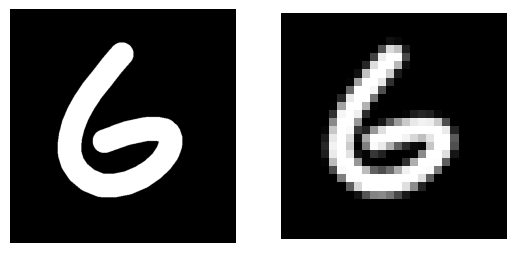

In [64]:
plt.subplot(1,2,1) #create subplot first
plt.imshow(image, cmap='gray')
plt.axis('off')

#dimensions need to be correct
plt.subplot(1,2,2)
plt.imshow(pixelated_image_visual, cmap='gray')
plt.axis('off') 

plt.show() #not needed for Jupyter